In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis Testing
from scipy.stats import ttest_ind, chi2_contingency

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
pd.set_option('display.expand_frame_repr', False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/liver_disease_data.csv')
df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,Male,35.857584,17.272828,No,Medium,0.658940,No,No,42.734240,Positive
1,71,Female,30.732470,2.201266,No,Medium,1.670557,Yes,No,67.309822,Positive
2,48,Male,19.971407,18.500944,No,Low,9.928308,No,No,63.738956,Negative
3,34,Female,16.615417,12.632870,No,Low,5.630129,No,No,64.555873,Positive
4,62,Female,16.065830,1.087815,No,Medium,3.566218,Yes,No,77.868689,Positive


# **Descriptive Statistics**

In [ ]:
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataset has 1700 rows and 11 columns.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1700 non-null   int64  
 1   Gender              1700 non-null   object 
 2   BMI                 1700 non-null   float64
 3   AlcoholConsumption  1700 non-null   float64
 4   Smoking             1700 non-null   object 
 5   GeneticRisk         1700 non-null   object 
 6   PhysicalActivity    1700 non-null   float64
 7   Diabetes            1700 non-null   object 
 8   Hypertension        1700 non-null   object 
 9   LiverFunctionTest   1700 non-null   float64
 10  Diagnosis           1700 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 146.2+ KB


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1700.000000,50.394118,17.641915,20.000000,35.000000,51.000000,66.000000,80.000000
BMI,1700.000000,27.699801,7.210400,15.004710,21.455414,27.925367,33.957668,39.992845
AlcoholConsumption,1700.000000,9.832309,5.757472,0.003731,4.841811,9.828195,14.871671,19.952456
PhysicalActivity,1700.000000,5.000993,2.847074,0.001852,2.622121,5.022883,7.401642,9.994964
LiverFunctionTest,1700.000000,59.863867,22.996262,20.019254,40.024216,59.513146,79.428755,99.991413


In [ ]:
missing_value_count =  df.isnull().sum()
duplicate_value_count = df.duplicated().sum()

if missing_value_count.sum().any() or duplicate_value_count > 0:
    print("Missing Values by Column:")
    print(missing_value_count[missing_value_count > 0])  # Show only columns with missing values
    print(f"Number of Duplicated Records: {duplicate_value_count}")
else:
    print("No missing values or duplicated records found.")

No missing values or duplicated records found.


In [ ]:
numeric_features = df.drop(columns=['Diagnosis']).select_dtypes(include=['number']).columns
categorical_features = df.drop(columns=['Diagnosis']).select_dtypes(exclude=['number']).columns
print(f"Numeric Features: {numeric_features.to_list()}")
print(f"Categorical Featues: {categorical_features.to_list()}")

Numeric Features: ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest']
Categorical Featues: ['Gender', 'Smoking', 'GeneticRisk', 'Diabetes', 'Hypertension']


In [ ]:
target_df = df.Diagnosis.value_counts().reset_index()
target_df['Percentage'] = (target_df['count'] / df.Diagnosis.count()) * 100
target_df

,Diagnosis,count,Percentage
0,Positive,936,55.058824
1,Negative,764,44.941176


# **Miscellaneous Functions**

In [ ]:
def crosstabulate(dataframe, feature, target, positive_label='Positive', negative_label='Negative', bins=10):
    df = dataframe.copy()

    # Use qcut to create equal-sized bins based on quantiles
    if pd.api.types.is_numeric_dtype(df[feature]):
        df['bin'] = pd.qcut(df[feature], q=bins)
        df['bin'] = df['bin'].apply(lambda x: pd.Interval(round(x.left, 3), round(x.right, 3), x.closed))
    else:
        df['bin'] = df[feature]

    # Group by bins and calculate events and non-events
    grouped = df.groupby('bin').agg(
        non_events=(target, lambda x: (x == negative_label).sum()),
        events=(target, lambda x: (x == positive_label).sum())
    ).reset_index()

    # Row-wise proportion (within each bin)
    grouped['proportion_of_non_events'] = grouped['non_events'] / (grouped['non_events'] + grouped['events'])
    grouped['proportion_of_events'] = grouped['events'] / (grouped['non_events'] + grouped['events'])

    return grouped

In [ ]:
# 100% Stacked Bar Chart
def plot_percentage_stacked_chart(grouped, title="Stacked Percentage Chart", xlabel="Bins", ylabel="Percentage", angle=0):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Create stacked bar chart with percentage values
    ax.bar(grouped['bin'].astype(str), grouped['proportion_of_non_events'] * 100, label='Negative', color='skyblue')
    ax.bar(grouped['bin'].astype(str), grouped['proportion_of_events'] * 100,
           bottom=grouped['proportion_of_non_events'] * 100, label='Positive', color='orange')

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title='Diagnosis')

    # Adjust legend position to avoid overlap
    ax.legend(title='Diagnosis', bbox_to_anchor=(1, 1))

    # Add percentage labels on each segment
    for idx, row in grouped.iterrows():
        ax.text(idx, row['proportion_of_non_events'] * 50, f"{row['proportion_of_non_events'] * 100:.1f}%", ha='center', color='black')
        ax.text(idx, (row['proportion_of_non_events'] + row['proportion_of_events']) * 75,
                f"{row['proportion_of_events'] * 100:.1f}%", ha='center', color='black')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=angle)
    plt.tight_layout()
    plt.show()

In [ ]:
def perform_statistical_test(df, feature, target, alpha=0.05):
    # Check if the feature is numeric or categorical
    if pd.api.types.is_numeric_dtype(df[feature]):
        # Perform two-sample t-test for numeric feature
        group_1 = df[df[target] == 'Negative'][feature]
        group_2 = df[df[target] == 'Positive'][feature]

        # Perform the t-test (Welch's t-test for unequal variance)
        t_stat, p_value = ttest_ind(group_1, group_2, equal_var=False)

        # Interpretation of p-value
        print(f"t-test: The p-value is {p_value:.4f}.")
        if p_value < alpha:
            print("We reject the null hypothesis (means are different).")
        else:
            print("We fail to reject the null hypothesis (means are the same).")

        # Boxplot to visualize the data distribution
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=target, y=feature, data=df)
        plt.title(f'Distribution of {feature} by {target}')
        plt.show()

    else:
        # Perform Chi-square test for categorical feature
        contingency_table = pd.crosstab(df[feature], df[target])

        # Perform the Chi-square test
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

        # Interpretation of p-value
        print(f"Chi-square test: The p-value is {p_value:.4f}.")
        if p_value < alpha:
            print("We reject the null hypothesis (the variables are dependent).")
        else:
            print("We fail to reject the null hypothesis (the variables are independent).")


In [ ]:
def calculate_woe(dataframe, feature, target, positive_label='Positive', negative_label='Negative', smoothing_factor=0.5):
    """
    Calculate Weight of Evidence (WoE) for a given categorical feature and target in a dataset.

    Parameters:
    - dataframe: The input DataFrame.
    - feature: The column name of the feature for which WoE is calculated.
    - target: The column name of the target variable (binary outcome).
    - smoothing_factor: A smoothing factor (default is 0.5) to handle zero values in bins.

    Returns:
    - woe_mapping: A dictionary mapping feature values to their WoE values.
    """
    if pd.api.types.is_numeric_dtype(dataframe[feature]):
        raise ValueError(f"Feature '{feature}' is numeric. WoE calculation is only applicable for categorical features.")

    df = dataframe.copy()
    df['bin'] = df[feature]

    grouped = df.groupby('bin').agg(
        non_events=(target, lambda x: (x == negative_label).sum()),
        events=(target, lambda x: (x == positive_label).sum())
    ).reset_index()

    total_non_events = grouped['non_events'].sum()
    total_events = grouped['events'].sum()

    grouped['proportion_of_non_events'] = (grouped['non_events'] + smoothing_factor) / total_non_events
    grouped['proportion_of_events'] = (grouped['events'] + smoothing_factor) / total_events

    grouped['woe'] = np.log(grouped['proportion_of_non_events'] / grouped['proportion_of_events'])

    return grouped.set_index('bin')['woe'].to_dict(), grouped


def calculate_iv(dataframe, feature, target, positive_label='Positive', negative_label='Negative', smoothing_factor=0.5):
    """
    Calculate Information Value (IV) for a given categorical feature and target in a dataset.

    Parameters:
    - dataframe: The input DataFrame.
    - feature: The column name of the feature for which IV is calculated.
    - target: The column name of the target variable (binary outcome).
    - smoothing_factor: A smoothing factor (default is 0.5) to handle zero values in bins.

    Returns:
    - total_iv: The total Information Value (IV).
    """
    _, grouped = calculate_woe(dataframe, feature, target, positive_label, negative_label, smoothing_factor)

    grouped['iv'] = (grouped['proportion_of_non_events'] - grouped['proportion_of_events']) * grouped['woe']

    return grouped['iv'].sum()

def replace_with_woe(original_dataset, factors, target):
    """
    Replace all categorical feature values in the dataset with their corresponding WoE values.

    Parameters:
    - original_dataset: The input DataFrame.
    - factors: List of categorical features to replace with WoE values.
    - target: The column name of the target variable.

    Returns:
    - woe_dataset: A DataFrame with WoE values.
    """
    woe_dataset = original_dataset.copy()
    for factor in factors:
        if pd.api.types.is_numeric_dtype(woe_dataset[factor]):
            raise ValueError(f"Feature '{factor}' is numeric. WoE replacement is only applicable for categorical features.")
        woe_values, _ = calculate_woe(original_dataset, factor, target)
        woe_dataset[factor] = woe_dataset[factor].map(woe_values)
    return woe_dataset

def iv_summary_table(dataframe, features, target):
    """
    Create a summary table with IV values and their interpretations for each categorical feature.

    Parameters:
    - dataframe: The input DataFrame.
    - features: List of categorical features for which IV is calculated.
    - target: The column name of the target variable.

    Returns:
    - iv_summary_df: A DataFrame summarizing IV values and interpretations.
    """
    iv_summary = {
        'Feature': [],
        'Total_IV': [],
        'Interpretation': []
    }

    for feature in features:
        if pd.api.types.is_numeric_dtype(dataframe[feature]):
            raise ValueError(f"Feature '{feature}' is numeric. IV calculation is only applicable for categorical features.")

        total_iv = calculate_iv(dataframe, feature, target)

        if total_iv < 0.02:
            category = "Not Useful"
        elif 0.02 <= total_iv < 0.1:
            category = "Weak"
        elif 0.1 <= total_iv < 0.3:
            category = "Medium"
        elif 0.3 <= total_iv < 0.5:
            category = "Strong"
        else:
            category = "Suspicious"

        iv_summary['Feature'].append(feature)
        iv_summary['Total_IV'].append(total_iv)
        iv_summary['Interpretation'].append(category)

    return pd.DataFrame(iv_summary)

# **Numeric Feature Vs Binary Target Variable**

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,"(19.999, 25.0]",98,76,0.563218,0.436782
1,"(25.0, 32.0]",91,87,0.511236,0.488764
2,"(32.0, 39.0]",89,79,0.529762,0.470238
3,"(39.0, 45.0]",114,72,0.612903,0.387097
4,"(45.0, 51.0]",78,91,0.461538,0.538462
5,"(51.0, 56.0]",56,106,0.345679,0.654321
6,"(56.0, 63.0]",48,120,0.285714,0.714286
7,"(63.0, 69.0]",66,102,0.392857,0.607143
8,"(69.0, 74.0]",66,94,0.412500,0.587500
9,"(74.0, 80.0]",58,109,0.347305,0.652695


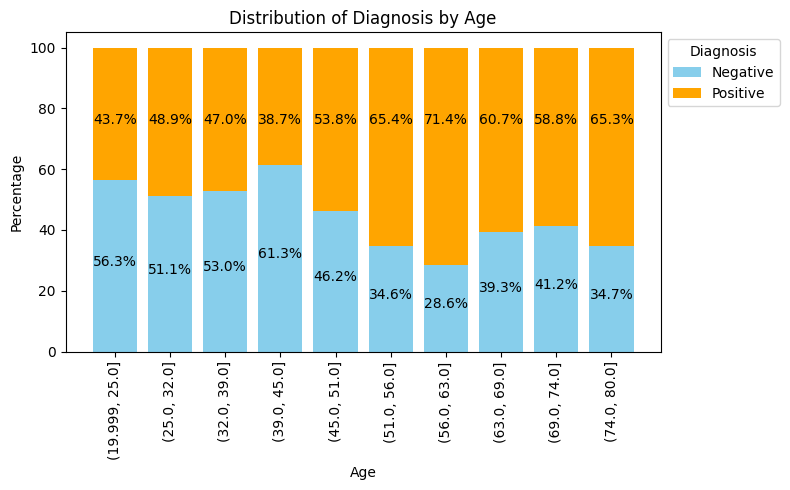

t-test: The p-value is 0.0000.
We reject the null hypothesis (means are different).


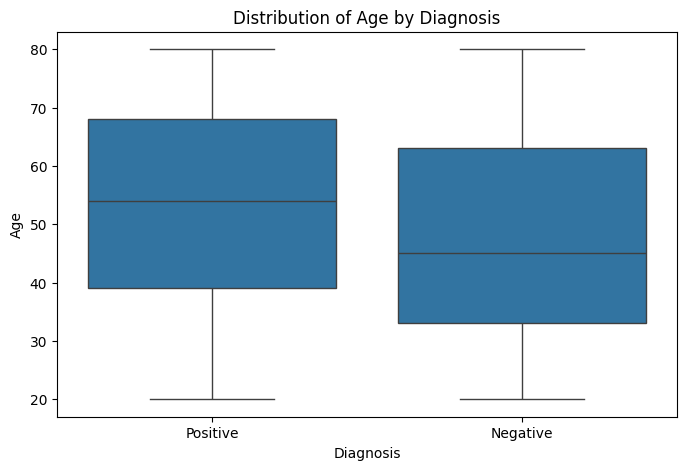

In [ ]:
# Age Vs Diagnosis
display(crosstabulate(df, 'Age', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'Age', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Age", xlabel="Age", angle=90)
perform_statistical_test(df, 'Age', 'Diagnosis')

Liver disease tends to become more prevalent in middle-aged and older individuals.
The lowest rates of positive diagnoses are observed in the youngest age group, whereas the highest rates are observed in individuals aged 51.0 – 63.0.
The higher median age and the concentration of cases in the 50–70 age range suggest that age is a significant risk factor.

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,"(15.004, 17.47]",95,75,0.558824,0.441176
1,"(17.47, 20.196]",107,63,0.629412,0.370588
2,"(20.196, 22.92]",91,79,0.535294,0.464706
3,"(22.92, 25.391]",86,84,0.505882,0.494118
4,"(25.391, 27.925]",71,99,0.417647,0.582353
5,"(27.925, 30.313]",64,106,0.376471,0.623529
6,"(30.313, 32.996]",58,112,0.341176,0.658824
7,"(32.996, 35.168]",65,105,0.382353,0.617647
8,"(35.168, 37.362]",64,106,0.376471,0.623529
9,"(37.362, 39.993]",63,107,0.370588,0.629412


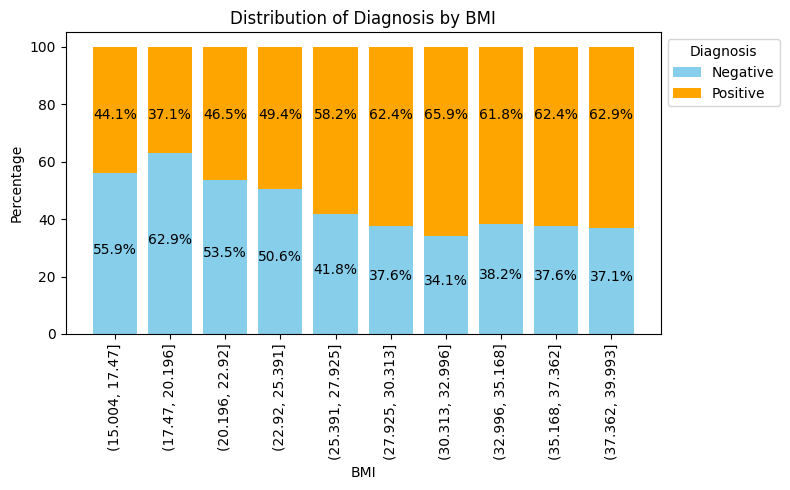

t-test: The p-value is 0.0000.
We reject the null hypothesis (means are different).


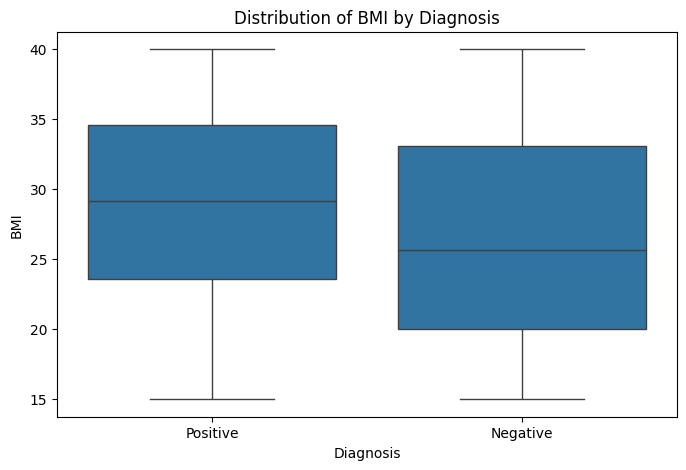

In [ ]:
# BMI Vs Diagnosis
display(crosstabulate(df, 'BMI', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'BMI', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by BMI", xlabel="BMI", angle=90)
perform_statistical_test(df, 'BMI', 'Diagnosis')


Liver disease prevalence increases with BMI, peaking in the overweight range (25.391 – 27.925) at 58.2% positive diagnoses. Beyond this, the proportion of positive diagnoses stabilizes around 62% – 65% in the overweight and obese categories. Lower BMI ranges have fewer positive cases, making BMI a strong predictor of liver disease risk.

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,"(0.003, 1.97]",116,54,0.682353,0.317647
1,"(1.97, 3.89]",104,66,0.611765,0.388235
2,"(3.89, 5.759]",106,64,0.623529,0.376471
3,"(5.759, 7.689]",115,55,0.676471,0.323529
4,"(7.689, 9.828]",105,65,0.617647,0.382353
5,"(9.828, 11.901]",57,113,0.335294,0.664706
6,"(11.901, 13.895]",40,130,0.235294,0.764706
7,"(13.895, 15.826]",33,137,0.194118,0.805882
8,"(15.826, 17.792]",42,128,0.247059,0.752941
9,"(17.792, 19.952]",46,124,0.270588,0.729412


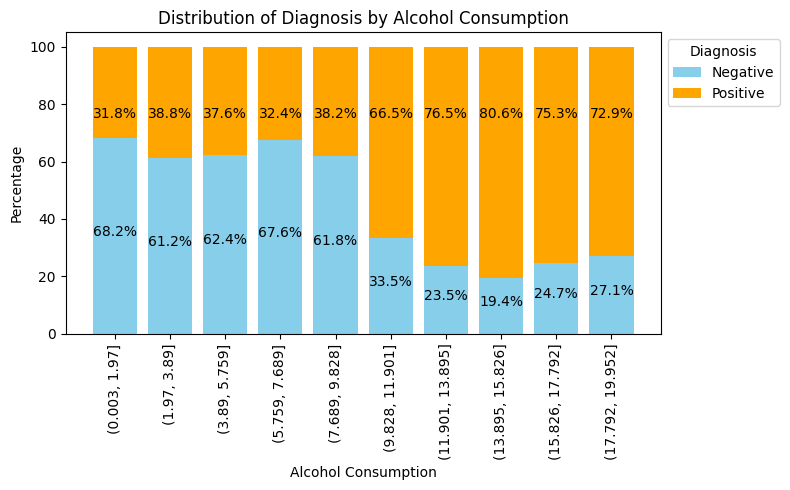

t-test: The p-value is 0.0000.
We reject the null hypothesis (means are different).


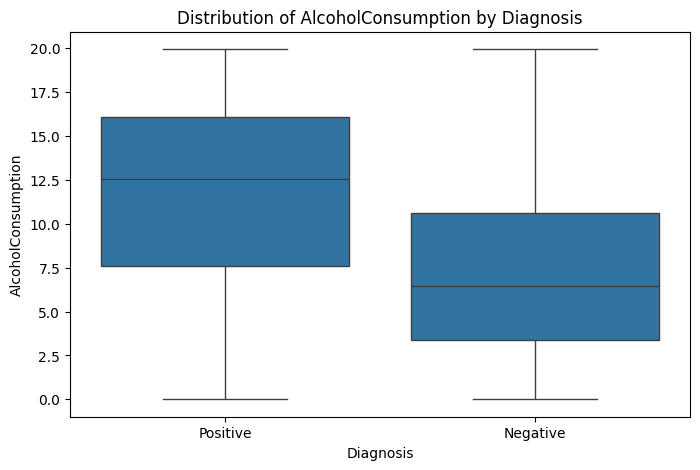

In [ ]:
# Alcohol Consumption Vs Diagnosis
display(crosstabulate(df, 'AlcoholConsumption', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'AlcoholConsumption', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Alcohol Consumption", xlabel="Alcohol Consumption", angle=90)
perform_statistical_test(df, 'AlcoholConsumption', 'Diagnosis')

Higher alcohol consumption strongly correlates with liver disease diagnosis. Those with positive diagnoses had nearly double the median alcohol consumption (approx. 12.5) compared to negative cases (approx. 6.5). A clear threshold effect appears around 9-11 consumption units, above which positive diagnoses become dominant (>65%). At the highest consumption levels (15+), about 75% of cases are positive for liver disease.

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,"(0.001, 0.992]",55,115,0.323529,0.676471
1,"(0.992, 2.103]",42,128,0.247059,0.752941
2,"(2.103, 3.103]",87,83,0.511765,0.488235
3,"(3.103, 4.157]",78,92,0.458824,0.541176
4,"(4.157, 5.023]",83,87,0.488235,0.511765
5,"(5.023, 5.991]",86,84,0.505882,0.494118
6,"(5.991, 6.885]",78,92,0.458824,0.541176
7,"(6.885, 7.918]",90,80,0.529412,0.470588
8,"(7.918, 8.97]",80,90,0.470588,0.529412
9,"(8.97, 9.995]",85,85,0.500000,0.500000


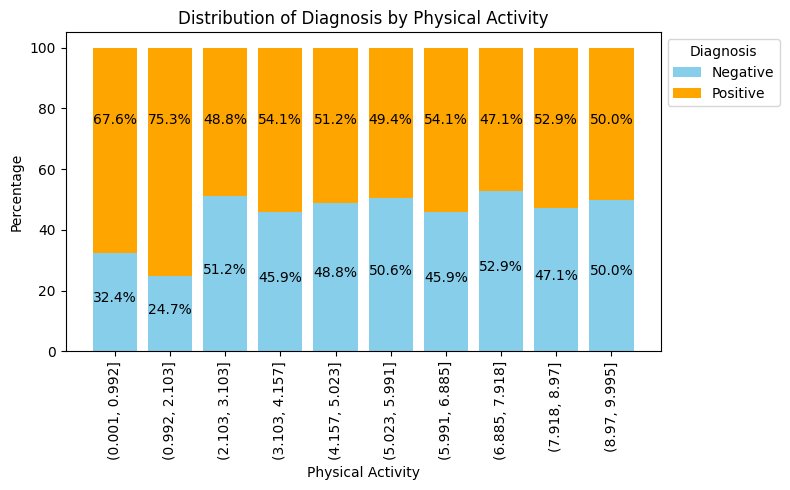

t-test: The p-value is 0.0000.
We reject the null hypothesis (means are different).


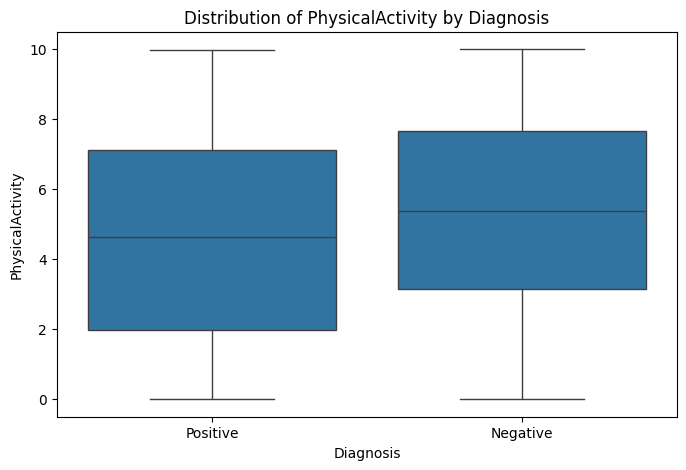

In [ ]:
# Physical Activity Vs Diagnosis
display(crosstabulate(df, 'PhysicalActivity', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'PhysicalActivity', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Physical Activity", xlabel="Physical Activity", angle=90)
perform_statistical_test(df, 'PhysicalActivity', 'Diagnosis')

Physical Activity shows a weaker relationship with liver disease diagnosis. The box plot shows only slightly higher physical activity levels in negative cases (median approx. 5.5) versus positive cases (median approx. ~4.5). The stacked bar chart reveals no clear trend, with diagnosis ratios remaining relatively consistent across different physical activity levels, though there's a slight indication that very low activity (0-2) may be associated with higher positive diagnoses.

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,"(20.018, 28.73]",127,43,0.747059,0.252941
1,"(28.73, 36.283]",116,54,0.682353,0.317647
2,"(36.283, 44.198]",120,50,0.705882,0.294118
3,"(44.198, 51.475]",106,64,0.623529,0.376471
4,"(51.475, 59.513]",49,121,0.288235,0.711765
5,"(59.513, 66.754]",54,116,0.317647,0.682353
6,"(66.754, 75.169]",51,119,0.300000,0.700000
7,"(75.169, 84.401]",47,123,0.276471,0.723529
8,"(84.401, 92.276]",48,122,0.282353,0.717647
9,"(92.276, 99.991]",46,124,0.270588,0.729412


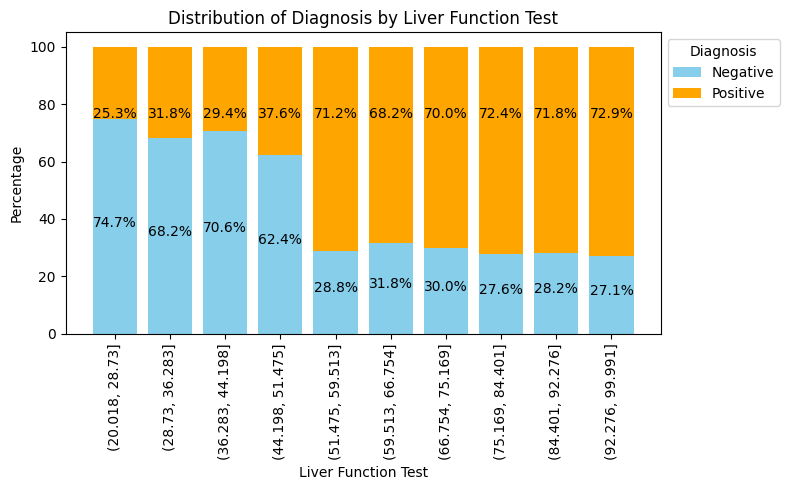

t-test: The p-value is 0.0000.
We reject the null hypothesis (means are different).


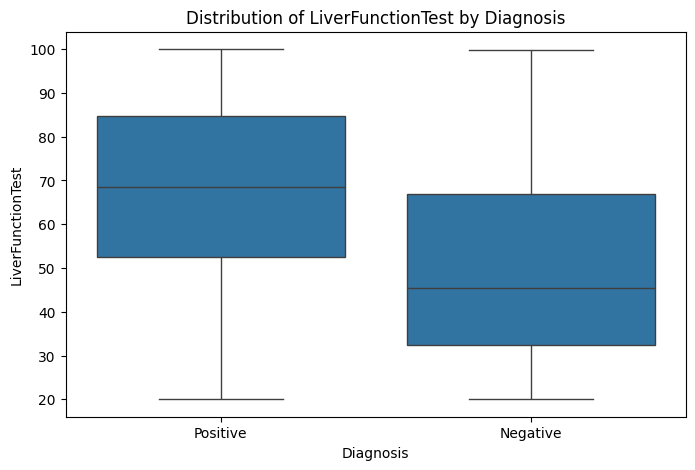

In [ ]:
# Liver Function Test Vs Diagnosis
display(crosstabulate(df, 'LiverFunctionTest', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'LiverFunctionTest', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Liver Function Test", xlabel="Liver Function Test", angle=90)
perform_statistical_test(df, 'LiverFunctionTest', 'Diagnosis')

The liver function test shows a strong correlation with diagnosis outcomes. In the box plot, positive cases have notably higher test values (median approx. 70) compared to negative cases (median approx. 4). The stacked bar chart demonstrates a clear progression: as liver function test values increase beyond approx. 50, the proportion of positive diagnoses dramatically rises from around 30% to over 70%. This suggests that liver function test values are a strong predictor of liver disease diagnosis.

# **Categorical Feature Vs Binary Target Variable**

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,Female,305,552,0.355893,0.644107
1,Male,459,384,0.544484,0.455516


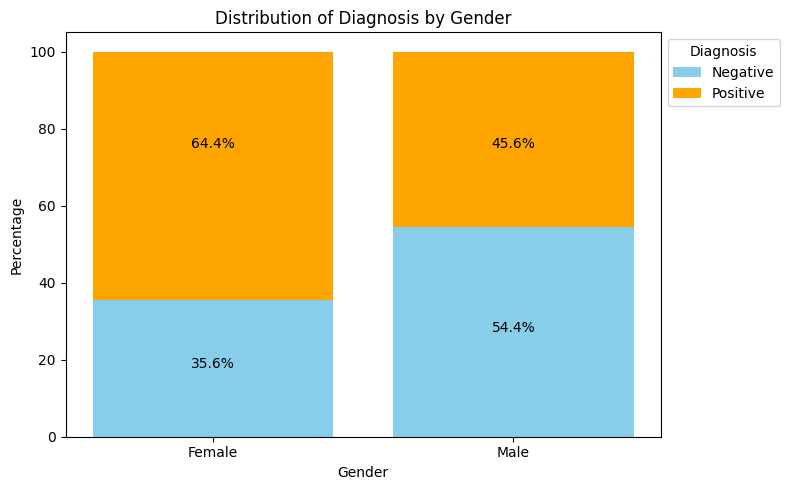

Chi-square test: The p-value is 0.0000.
We reject the null hypothesis (the variables are dependent).


In [ ]:
# Gender Vs Diagnosis
display(crosstabulate(df, 'Gender', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'Gender', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Gender", xlabel="Gender")
perform_statistical_test(df, 'Gender', 'Diagnosis')

The data shows a gender disparity in liver disease diagnosis. Women have a higher positive diagnosis rate (64.4%) compared to men (45.6%). Men show more negative cases (54.4%) than women (35.6%).

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,No,618,586,0.513289,0.486711
1,Yes,146,350,0.294355,0.705645


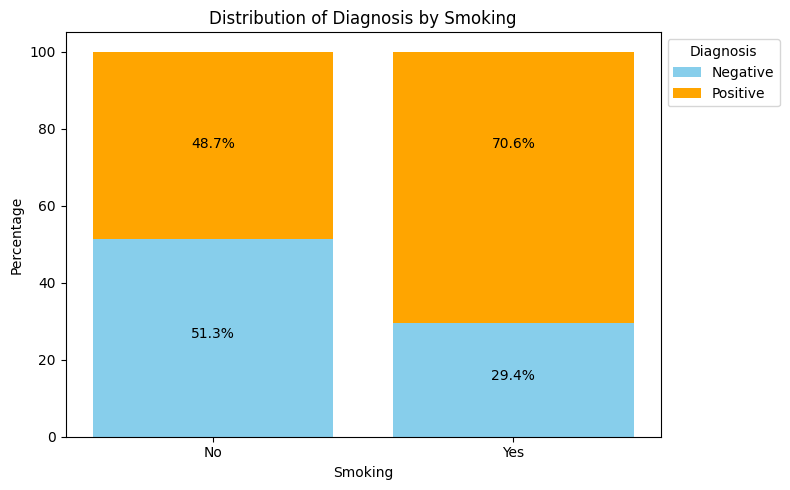

Chi-square test: The p-value is 0.0000.
We reject the null hypothesis (the variables are dependent).


In [ ]:
# Smoking Vs Diagnosis
display(crosstabulate(df, 'Smoking', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'Smoking', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Smoking", xlabel="Smoking")
perform_statistical_test(df, 'Smoking', 'Diagnosis')

Smokers show significantly higher liver disease rates (70.6% positive) compared to non-smokers (48.7% positive). Non-smokers have a more balanced distribution with slightly more negative cases (51.3%) than positive.

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,High,27,138,0.163636,0.836364
1,Low,459,519,0.469325,0.530675
2,Medium,278,279,0.499102,0.500898


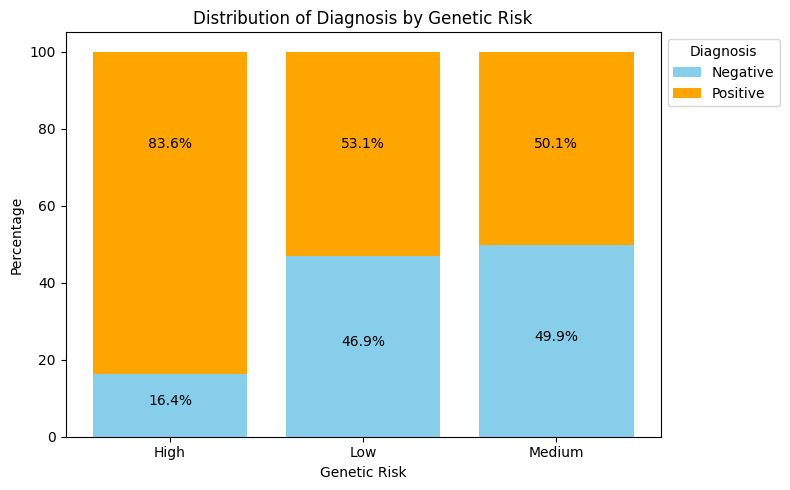

Chi-square test: The p-value is 0.0000.
We reject the null hypothesis (the variables are dependent).


In [ ]:
# Genetic Risk Vs Diagnosis
display(crosstabulate(df, 'GeneticRisk', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'GeneticRisk', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Genetic Risk", xlabel="Genetic Risk")
perform_statistical_test(df, 'GeneticRisk', 'Diagnosis')

Genetic risk is a significant factor in the likelihood of a positive diagnosis. Higher genetic risk correlates strongly with a higher percentage of positive diagnoses. Individuals with low genetic risk are much more likely to have a negative diagnosis.



,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,No,687,771,0.471193,0.528807
1,Yes,77,165,0.318182,0.681818


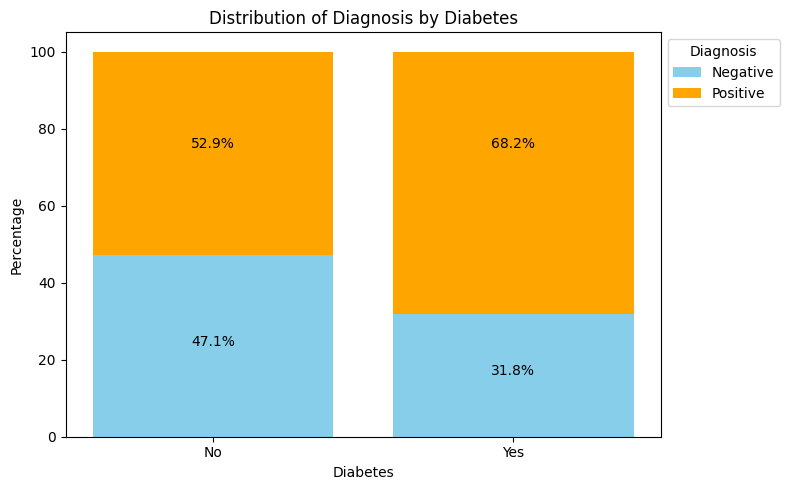

Chi-square test: The p-value is 0.0000.
We reject the null hypothesis (the variables are dependent).


In [ ]:
# Diabetes Vs Diagnosis
display(crosstabulate(df, 'Diabetes', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'Diabetes', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Diabetes", xlabel="Diabetes")
perform_statistical_test(df, 'Diabetes', 'Diagnosis')

There is a 15.3% increase in positive diagnoses among individuals with diabetes (68.2%) compared to those without diabetes (52.9%). This indicates that diabetes significantly elevates the risk of a positive diagnosis for liver disease.

,bin,non_events,events,proportion_of_non_events,proportion_of_events
0,No,698,739,0.485734,0.514266
1,Yes,66,197,0.250951,0.749049


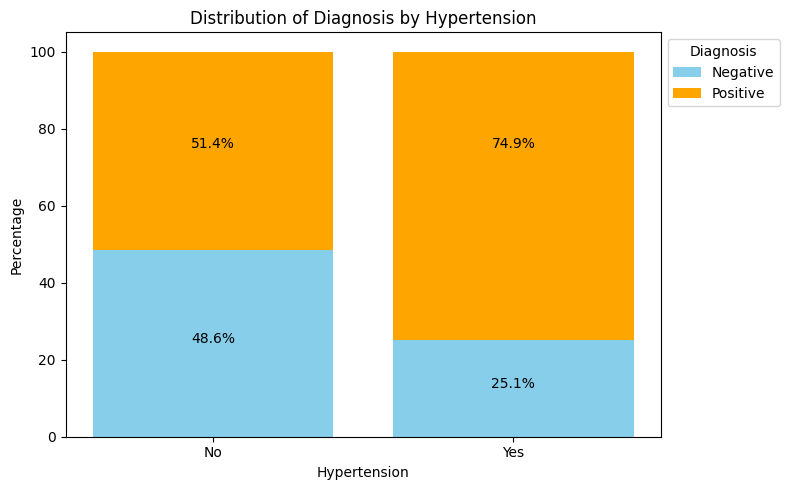

Chi-square test: The p-value is 0.0000.
We reject the null hypothesis (the variables are dependent).


In [ ]:
# Hypertension Vs Diagnosis
display(crosstabulate(df, 'Hypertension', 'Diagnosis'))
feature_crosstab = crosstabulate(df, 'Hypertension', 'Diagnosis')
plot_percentage_stacked_chart(feature_crosstab, title="Distribution of Diagnosis by Hypertension", xlabel="Hypertension")
perform_statistical_test(df, 'Hypertension', 'Diagnosis')

 The percentage of positive diagnoses increases significantly (from 51.4% to 74.9%) when hypertension is present.

Individuals without hypertension have a nearly balanced distribution between positive and negative diagnoses, with a slight majority (51.4%) having a positive diagnosis.

# **Correlation Analysis**

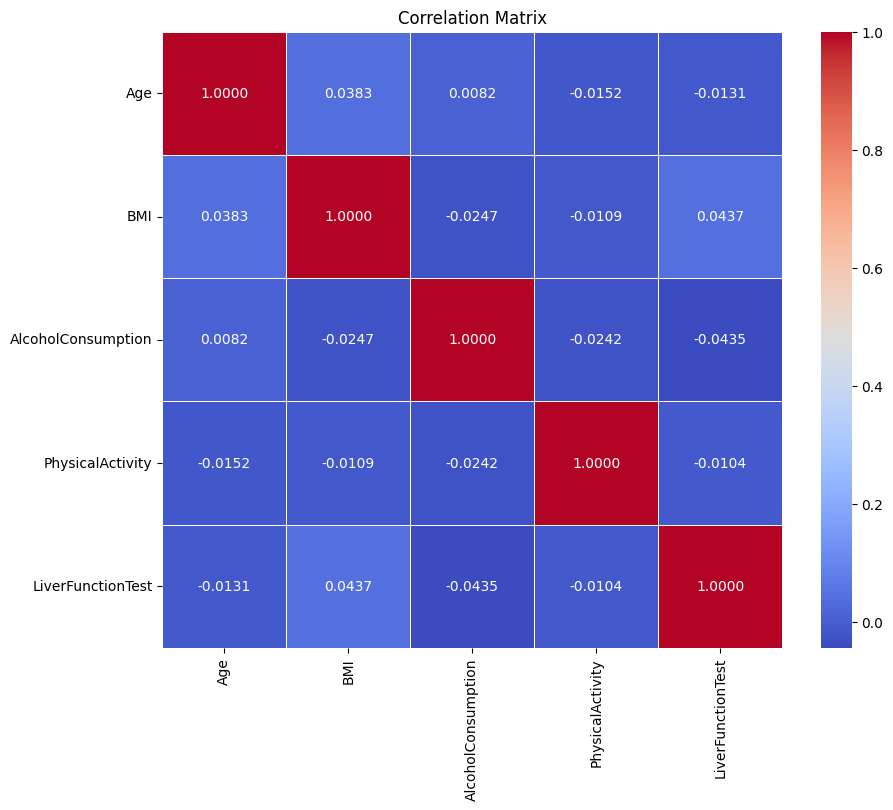

In [ ]:
# Calculate the Correlation Matrix
numeric_corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr_matrix, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# **Others**

**Replacing Categorical Features with their WoE Transformed Values**

In [ ]:
woe_df = replace_with_woe(df, categorical_features, 'Diagnosis')
woe_df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0.381243,35.857584,17.272828,0.256172,0.199463,0.658940,0.087773,0.146009,42.734240,Positive
1,71,-0.389456,30.732470,2.201266,0.256172,0.199463,1.670557,-0.555646,0.146009,67.309822,Positive
2,48,0.381243,19.971407,18.500944,0.256172,0.080320,9.928308,0.087773,0.146009,63.738956,Negative
3,34,-0.389456,16.615417,12.632870,0.256172,0.080320,5.630129,0.087773,0.146009,64.555873,Positive
4,62,-0.389456,16.065830,1.087815,0.256172,0.199463,3.566218,-0.555646,0.146009,77.868689,Positive


In [ ]:
iv_summary_table(df, categorical_features, 'Diagnosis')

,Feature,Total_IV,Interpretation
0,Gender,0.146839,Medium
1,Smoking,0.169154,Medium
2,GeneticRisk,0.175169,Medium
3,Diabetes,0.048520,Weak
4,Hypertension,0.127902,Medium


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
woe_df[numeric_features] = scaler.fit_transform(woe_df[numeric_features])

# Map the Target Variable
woe_df["Diagnosis"] = woe_df["Diagnosis"].map({"Positive": 1, "Negative": 0})
woe_df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,0.431253,0.381243,1.131724,1.292704,0.256172,0.199463,-1.525542,0.087773,0.146009,-0.745107,1
1,1.168351,-0.389456,0.420720,-1.325806,0.256172,0.199463,-1.170119,-0.555646,0.146009,0.323885,1
2,-0.135746,0.381243,-1.072155,1.506075,0.256172,0.080320,1.731169,0.087773,0.146009,0.168559,0
3,-0.929544,-0.389456,-1.537730,0.486565,0.256172,0.080320,0.221042,0.087773,0.146009,0.204093,1
4,0.658052,-0.389456,-1.613973,-1.519255,0.256172,0.199463,-0.504096,-0.555646,0.146009,0.783176,1
